In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA

In [16]:
path = "data/"
seed = 0
column_dict = {0:"Smiles",
               1:"Task1", 2:"Task2", 3:"Task3", 4:"Task4", 5:"Task5", 6:"Task6", 7:"Task7", 8:"Task8", 9:"Task9"}
columns_list = list(column_dict.values())
desc_names = [desc[0] for desc in Chem.Descriptors._descList]

In [17]:
x = pd.read_csv("{}smiles_train.csv".format(path))
y = pd.read_csv("{}y_train.csv".format(path), na_values="-1")
df = pd.concat([x, y],axis=1, ignore_index = True)
df = df.rename(columns=column_dict)
print(df.shape)
df.head()

(18156, 10)


,Smiles,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
0,O=C(Nc1ccccc1F)c1csc([N+](=O)[O-])c1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
1,C[C@H]([C@H]1C[C@]1(C)[C@H](NC(=O)OCc2ccccc2)c...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,C[C@H]([C@@H]1C[C@@]1(C)[C@@H](NC(=O)OCc2ccccc...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,COc1ccc(CO\N=C\c2c(C)nc(O)nc2O)cc1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,CCN1CCC[C@H]1CNC(=O)c2c(O)c(CC)cc(Cl)c2OC,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [18]:
df = df.drop_duplicates(ignore_index=True)
df.shape
num_mol = df.shape[0]
#Check for null values
print(df.columns[df.isnull().sum() > 0])

Index(['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7', 'Task8',
       'Task9'],
      dtype='object')


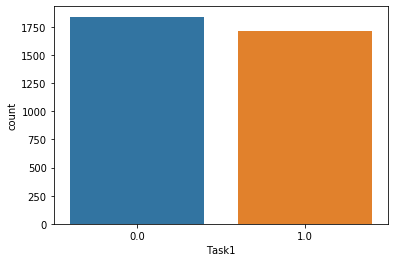

0.0    1842
1.0    1712
Name: Task1, dtype: int64


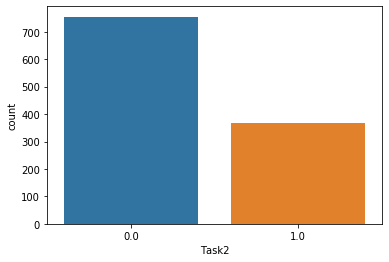

0.0    755
1.0    366
Name: Task2, dtype: int64


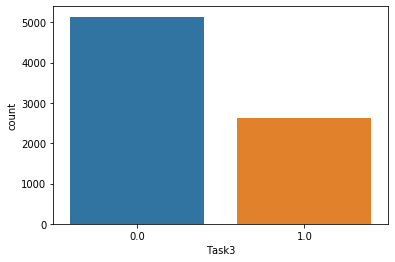

0.0    5139
1.0    2636
Name: Task3, dtype: int64


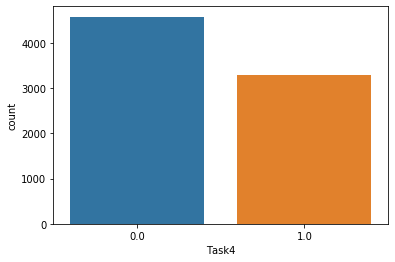

0.0    4579
1.0    3282
Name: Task4, dtype: int64


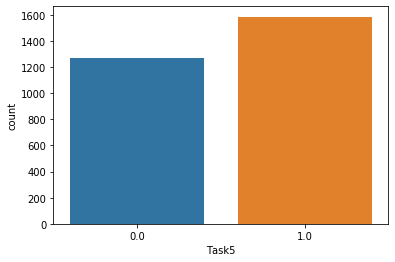

1.0    1586
0.0    1267
Name: Task5, dtype: int64


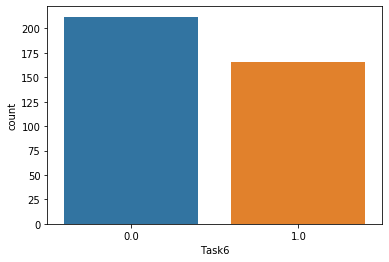

0.0    212
1.0    166
Name: Task6, dtype: int64


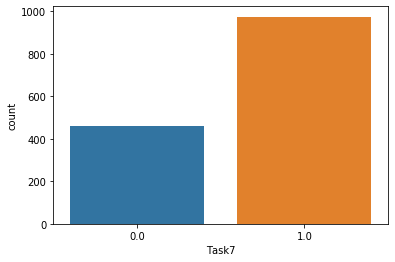

1.0    974
0.0    462
Name: Task7, dtype: int64


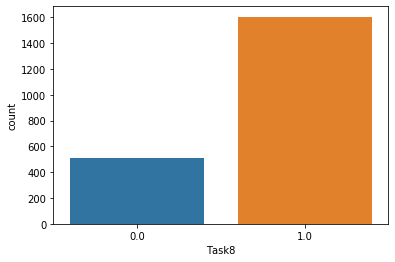

1.0    1605
0.0     509
Name: Task8, dtype: int64


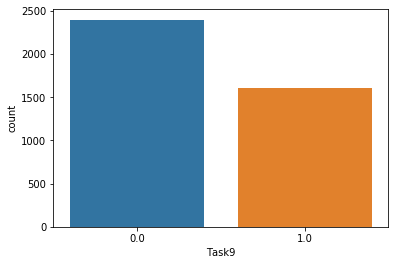

0.0    2398
1.0    1602
Name: Task9, dtype: int64


In [19]:
#Show data (im)balance
for target in columns_list[1:]:
    sns.countplot(x=target, data=df)
    plt.show()
    print(df[target].value_counts())

# Train

In [20]:
def get_Descriptors(df, desc_names):
    num_mol = len(df["Smiles"])
    mol_desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
    desc_mat = np.zeros((num_mol,len(desc_names)))
    verbosity = int(num_mol*0.05)
    for i in range(num_mol):
        smile = df["Smiles"][i]
        if  i % verbosity == 0:
            print("{} out of {} = {}%".format(i,num_mol, int(i*100/num_mol)))
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            print("Invalid Molecule at index {}, {}".format(i,smile))
            desc_mat[i] = np.nan
        else:
            desc_mat[i] = mol_desc_calc.CalcDescriptors(mol)
    
    df_desc = pd.DataFrame(desc_mat, columns = desc_names)
    df_desc = df_desc.replace([np.inf, -np.inf], np.nan)
    print(df_desc.columns[df_desc.isnull().sum() > 0])
    df_desc = df_desc.fillna(df_desc.median())
    print(df_desc.columns[df_desc.isnull().sum() > 0])
    
    return df_desc

In [21]:
df_desc = get_Descriptors(df, desc_names)
df_desc.head()

0 out of 18122 = 0%
906 out of 18122 = 4%
1812 out of 18122 = 9%
2718 out of 18122 = 14%
3624 out of 18122 = 19%
4530 out of 18122 = 24%
5436 out of 18122 = 29%
6342 out of 18122 = 34%
7248 out of 18122 = 39%
8154 out of 18122 = 44%
9060 out of 18122 = 49%
9966 out of 18122 = 54%
10872 out of 18122 = 59%
11778 out of 18122 = 64%
12684 out of 18122 = 69%
13590 out of 18122 = 74%
14496 out of 18122 = 79%
15402 out of 18122 = 84%
16308 out of 18122 = 89%
17214 out of 18122 = 94%
18120 out of 18122 = 99%
Index(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge'],
      dtype='object')
Index([], dtype='object')


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.278775,-0.579213,13.278775,0.038290,0.685096,266.253,259.197,266.016141,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,12.662032,-0.434797,12.662032,0.086017,0.609790,420.553,388.297,420.241293,164.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.662032,-0.434797,12.662032,0.086017,0.609790,420.553,388.297,420.241293,164.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.574412,-0.484906,9.574412,0.277028,0.642690,289.291,274.171,289.106256,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.589046,-0.347682,12.589046,0.050908,0.835583,340.851,315.651,340.155370,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Drop non info columns
df = df.drop(["Smiles"], axis = 1)

print(df_desc.shape)
mono_columns = df_desc.columns[[len(np.unique(df_desc[col])) == 1 for col in df_desc.columns]]
df_desc = df_desc.drop(mono_columns,axis = 1)
df_desc.shape

(18122, 200)


(18122, 197)

In [23]:
corr = df_desc.corr()
high_corr_attr = corr[(corr.abs()>0.9)].count().sort_values(ascending= False)
print(list(high_corr_attr))
correlated_columns = list(high_corr_attr[high_corr_attr > 10].index)
print(correlated_columns)
df_desc = df_desc.drop(correlated_columns,axis = 1)
df_desc.shape

[16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 12, 7, 5, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
['Chi1v', 'LabuteASA', 'Chi0n', 'Chi0v', 'Chi1', 'HeavyAtomCount', 'NumValenceElectrons', 'MolMR', 'Chi1n', 'Chi2n', 'Chi0', 'ExactMolWt', 'MolWt', 'HeavyAtomMolWt']


(18122, 183)

In [24]:
data = pd.concat([df_desc, df],axis=1, ignore_index = True)
data.columns = list(df_desc.columns) + list(df.columns)

appendix = "desc_"
data.to_csv("{}{}train.csv".format(path,appendix), index=None)
data.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_urea,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
0,13.278775,-0.579213,13.278775,0.038290,0.685096,0.0,0.324371,-0.319424,0.324371,0.319424,...,0.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0
1,12.662032,-0.434797,12.662032,0.086017,0.609790,0.0,0.407471,-0.444678,0.444678,0.407471,...,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,12.662032,-0.434797,12.662032,0.086017,0.609790,0.0,0.407471,-0.444678,0.444678,0.407471,...,0.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,9.574412,-0.484906,9.574412,0.277028,0.642690,0.0,0.316957,-0.496768,0.496768,0.316957,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,12.589046,-0.347682,12.589046,0.050908,0.835583,0.0,0.258466,-0.506680,0.506680,0.258466,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


# Test Data

In [25]:
x_test = pd.read_csv("{}smiles_test.csv".format(path))
x_test.head()

,Smiles
0,OC(=O)CCC(=O)c1ccc2ccc3cccc4ccc1c2c34
1,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
2,Clc1ccc(cc1)n2nnnc2CN3CCOCC3
3,CC1(C)C2(C)CCC1(OC2=O)C(=O)Nc3ncc(s3)[N+](=O)[O-]
4,CCOC(=O)C[C@@H](CC(=O)C)C(=O)OCC


In [26]:
test_data = get_Descriptors(x_test, desc_names)
test_data.head()

0 out of 9470 = 0%
473 out of 9470 = 4%
946 out of 9470 = 9%
1419 out of 9470 = 14%
1892 out of 9470 = 19%
2365 out of 9470 = 24%
2838 out of 9470 = 29%
3311 out of 9470 = 34%
3784 out of 9470 = 39%
4257 out of 9470 = 44%
4730 out of 9470 = 49%
5203 out of 9470 = 54%
5676 out of 9470 = 59%
6149 out of 9470 = 64%
6622 out of 9470 = 69%
7095 out of 9470 = 74%
7568 out of 9470 = 79%
8041 out of 9470 = 84%
8514 out of 9470 = 89%
8987 out of 9470 = 94%
9460 out of 9470 = 99%
Index(['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge'],
      dtype='object')
Index([], dtype='object')


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.432081,-0.948091,12.432081,0.027087,0.441438,302.329,288.217,302.094294,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.857397,0.392174,5.857397,0.392174,0.417884,393.443,370.259,393.168856,150.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
2,5.885438,0.700513,5.885438,0.700513,0.843511,279.731,265.619,279.088688,100.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,12.685397,-1.250711,12.685397,0.123544,0.517339,325.346,310.226,325.073242,118.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,11.436250,-0.725463,11.436250,0.011555,0.612348,230.260,212.116,230.115424,92.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
print(test_data.shape)
test_data = test_data.drop(mono_columns,axis = 1)
test_data = test_data.drop(correlated_columns,axis = 1)
test_data.shape

(9470, 200)


(9470, 183)

In [28]:
appendix = "desc_"
test_data.to_csv("{}{}test.csv".format(path, appendix),index=None)